In [ ]:
!pip install transformers
!pip install Sastrawi
!pip install datasets
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00


In [ ]:
!pip install accelerate>=0.21.0


In [ ]:
!pip show accelerate


Name: accelerate
Version: 0.30.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
!pip show transformers


Name: transformers
Version: 4.41.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, TrainingArguments

lb = LabelEncoder()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
file_path = '/content/Dataset_BIMTEK .xlsx'
df = pd.read_excel(file_path)

df.head()

,laporan,label,story
0,hadapan pemuka Agama Hindu yang bernama Mangku...,perdata,Seseorang mengalami masalah perceraian dengan ...
1,ngkan secara adat Bali dan agama Hindu pada ta...,perdata,Seseorang mengalami masalah perceraian dengan ...
2,Menyatakan Tergugat telah dipanggil dengan pat...,perdata,Seseorang yang mengalami perceraian dengan Ter...
3,Menyatakan Tergugat telah dipanggil dengan pat...,perdata,Seseorang mengalami masalah karena Tergugat ti...
4,Menyatakan Tergugat telah dipanggil dengan pat...,perdata,Seseorang mengalami masalah karena Tergugat ti...


In [ ]:
df = df.drop("laporan", axis=1)

In [ ]:
df.head()

,label,story
0,perdata,Seseorang mengalami masalah perceraian dengan ...
1,perdata,Seseorang mengalami masalah perceraian dengan ...
2,perdata,Seseorang yang mengalami perceraian dengan Ter...
3,perdata,Seseorang mengalami masalah karena Tergugat ti...
4,perdata,Seseorang mengalami masalah karena Tergugat ti...


In [ ]:
df.isnull().sum()

label    0
story    0
dtype: int64

In [ ]:
def DataPrep(story) :
    story = re.sub('<.*?>', '', story)
    story = re.sub(r'http\S+', '', story)
    story = re.sub(r'@\S+', '', story)
    story = re.sub(r'#\S+', '', story)
    story = re.sub(r'\d+', '', story)
    story = re.sub(r'[^\w\s]', '', story)
    story = re.sub(r'@(\w+)', '', story)

    # Tokenize text
    tokens = story.split()
    # Remove punctuation tokens
    punc = list(punctuation)
    words = [w for w in tokens if w not in punc]

    # Remove stop words
    stop_words = set(stopwords.words('indonesian'))
    words = [w.lower() for w in words if not w.lower() in stop_words]

    # Stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemming_tokens = [stemmer.stem(token) for token in words]

    text = ' '.join(stemming_tokens)
    return text

df['story'] = df['story'].astype(str).apply(DataPrep)

In [ ]:
df.drop_duplicates("story", inplace=True)
df.head()

,label,story
0,perdata,alami cerai mang i komang don sebab anakanak g...
1,perdata,alami cerai pasang adat bal agama hindu lurah ...
2,perdata,alami cerai gugat tanggal mei kabupaten jembra...
3,perdata,alami gugat hadir panggil adil gugat gugat kab...
4,perdata,alami gugat hadir panggil adil gugat menang gu...


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [ ]:
# Define the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("archi-ai/Indo-LegalBERT")
model = AutoModelForSequenceClassification.from_pretrained(
    "archi-ai/Indo-LegalBERT",
    num_labels=3
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at archi-ai/Indo-LegalBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['story'], padding="max_length", truncation=True)

In [ ]:
# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/521 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# Split the dataset into train and test sets
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [ ]:
# Define data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Updated parameter name
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.476210
2,No log,0.387072
3,No log,0.382693


TrainOutput(global_step=156, training_loss=0.37041495396540713, metrics={'train_runtime': 1865.8957, 'train_samples_per_second': 0.669, 'train_steps_per_second': 0.084, 'total_flos': 62789087754624.0, 'train_loss': 0.37041495396540713, 'epoch': 3.0})

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.3826932907104492, 'eval_runtime': 45.9223, 'eval_samples_per_second': 2.286, 'eval_steps_per_second': 0.305, 'epoch': 3.0}


In [ ]:
model.save_pretrained('./legal_classification_model')
tokenizer.save_pretrained('./legal_classification_model')

('./legal_classification_model/tokenizer_config.json',
 './legal_classification_model/special_tokens_map.json',
 './legal_classification_model/vocab.txt',
 './legal_classification_model/added_tokens.json',
 './legal_classification_model/tokenizer.json')

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = './legal_classification_model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)


In [ ]:
user_input = "saya setubuhi anak saya"
processed_input = DataPrep(user_input)

In [ ]:
import torch

# Tokenisasi input pengguna
tokenized_input = tokenizer(processed_input, padding="max_length", truncation=True, return_tensors="pt")

# Prediksi label
outputs = model(**tokenized_input)
predicted_label = torch.argmax(outputs.logits, dim=1).item()

# Ubah label kembali ke label asli
predicted_label = label_encoder.inverse_transform([predicted_label])[0]


In [ ]:
print("Prediksi label:", predicted_label)


Prediksi label: pidana


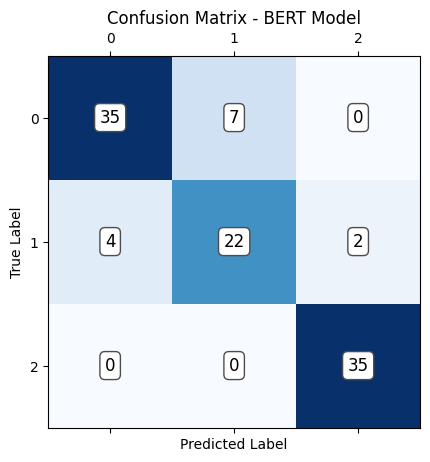

In [ ]:
from sklearn.metrics import confusion_matrix

# Prediksi label untuk dataset uji
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = test_dataset['label']

# Hitung confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)


plt.matshow(cm, cmap=plt.cm.Blues)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=12, bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - BERT Model')
plt.show()